In [272]:
import geopandas as gpd
import re
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

gm = gpd.read_parquet('data/gemeenten/gemeenten_stats.parquet')
wk = gpd.read_parquet('data/wijken/wijken_stats.parquet')
bu = gpd.read_parquet('data/buurten/buurten_stats.parquet')


,gemeentecode,gemeentenaam,H2O,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,...,L1_altieri_0_T,L1_altieri_0_norm,L0_altieri_1_T,L0_altieri_1_norm,L1_altieri_1_T,L1_altieri_1_norm,L0_altieri_2_T,L0_altieri_2_norm,L1_altieri_2_T,L1_altieri_2_norm
0,GM0014,Groningen,NEE,3427.0,1.0,1284.0,238147.0,118198.0,119949.0,12.0,...,6.998096,0.703755,6.066780,0.984033,8.816592,0.941965,6.047942,0.984144,8.296879,0.951659
1,GM0034,Almere,NEE,1629.0,2.0,1725.0,222825.0,110589.0,112236.0,18.0,...,4.133285,0.537418,4.095770,0.926111,5.668782,0.805383,4.058943,0.917844,5.347846,0.814765
2,GM0037,Stadskanaal,NEE,840.0,4.0,273.0,32135.0,15844.0,16291.0,14.0,...,3.716001,0.691287,2.647907,0.665669,3.386861,0.456184,2.562058,0.632142,3.141528,0.432481
3,GM0047,Veendam,NEE,1013.0,3.0,364.0,27616.0,13863.0,13753.0,14.0,...,4.491804,0.789606,3.366334,0.871421,4.314221,0.640831,3.246352,0.822980,4.037118,0.632867
4,GM0050,Zeewolde,NEE,842.0,4.0,96.0,23692.0,12003.0,11689.0,17.0,...,4.033160,0.781816,2.796831,0.743212,3.956966,0.661360,2.771071,0.739210,3.688725,0.648370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,GM1979,Eemsdelta,NEE,710.0,4.0,169.0,45394.0,22743.0,22651.0,14.0,...,4.225991,0.836856,3.090507,0.896124,3.999106,0.676526,3.020617,0.867041,3.783098,0.685604
338,GM1980,Dijk en Waard,NEE,1478.0,3.0,1438.0,88985.0,44617.0,44368.0,17.0,...,3.877066,0.630988,3.437325,0.904835,4.735554,0.777904,3.365904,0.878340,4.442224,0.777348
339,GM1982,Land van Cuijk,NEE,645.0,4.0,268.0,91423.0,46152.0,45271.0,14.0,...,4.020137,0.778098,3.078554,0.889901,4.179531,0.741459,3.036333,0.875092,3.941256,0.748003
340,GM1991,Maashorst,NEE,1186.0,3.0,429.0,58934.0,29428.0,29506.0,15.0,...,2.083431,0.168185,3.407205,0.890658,4.985829,0.859326,3.392937,0.890858,4.646263,0.850118


In [273]:
# Matches all entropy columns
for gdf in [gm, wk, bu]:
    regex = re.compile(r'L\d{1}_(shannon|altieri|leibovici)_\d{1}') 

    cols = [col for col in gdf.columns if regex.match(col)]
    cols

    for col in cols:
        gdf.loc[:, f'{col}_T'] = gdf[col] / (np.emath.logn(5, gdf.STED) + 1)
        gdf.loc[:, f'{col}_norm'] = (gdf[col] - gdf[col].min()) / (gdf[col].max() - gdf[col].min())

# gm.to_parquet('data/gemeenten/gemeenten_stats.parquet')
# wk.to_parquet('data/wijken/wijken_stats.parquet')
# bu.to_parquet('data/buurten/buurten_stats.parquet')        

gdf.head(3)

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,IND_WBI,H2O,POSTCODE,DEK_PERC,OAD,...,L1_shannon_1_norm_T,L1_shannon_1_norm_norm,L0_shannon_2_T_T,L0_shannon_2_T_norm,L0_shannon_2_norm_T,L0_shannon_2_norm_norm,L1_shannon_2_T_T,L1_shannon_2_T_norm,L1_shannon_2_norm_T,L1_shannon_2_norm_norm
0,BU00140000,Binnenstad-Noord,WK001400,GM0014,Groningen,1.0,NEE,9712,1.0,6865.0,...,0.856103,0.856103,2.147853,0.706921,0.689335,0.689335,3.749752,0.885111,0.871942,0.871942
1,BU00140001,Binnenstad-Zuid,WK001400,GM0014,Groningen,1.0,NEE,9711,1.0,6586.0,...,0.873691,0.873691,2.125112,0.699437,0.682036,0.682036,3.806012,0.898391,0.885024,0.885024
2,BU00140002,Binnenstad-Oost,WK001400,GM0014,Groningen,1.0,NEE,9711,3.0,6264.0,...,0.869875,0.869875,2.453244,0.807434,0.787347,0.787347,3.727877,0.879947,0.866855,0.866855


<Axes: >

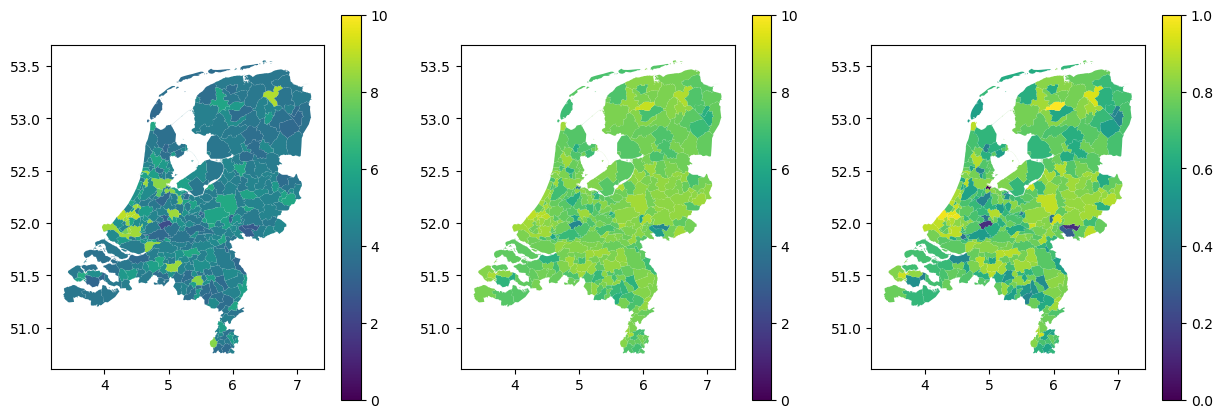

In [277]:

measure = "altieri"

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

gm.plot(column=f'L1_{measure}_1_T', ax=ax[0], legend=True, vmin=0, vmax=10)
gm.plot(column=f'L1_{measure}_1', ax=ax[1], legend=True, vmin=0, vmax=10)
gm.plot(column=f'L1_{measure}_1_norm', ax=ax[2], legend=True, vmin=0, vmax=1)


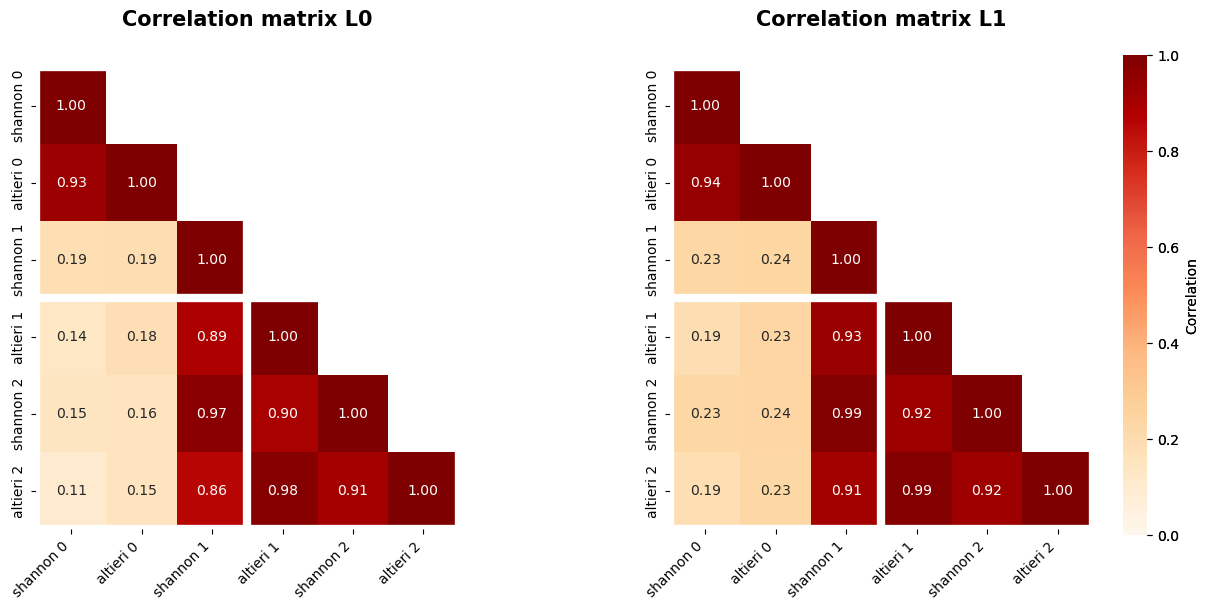

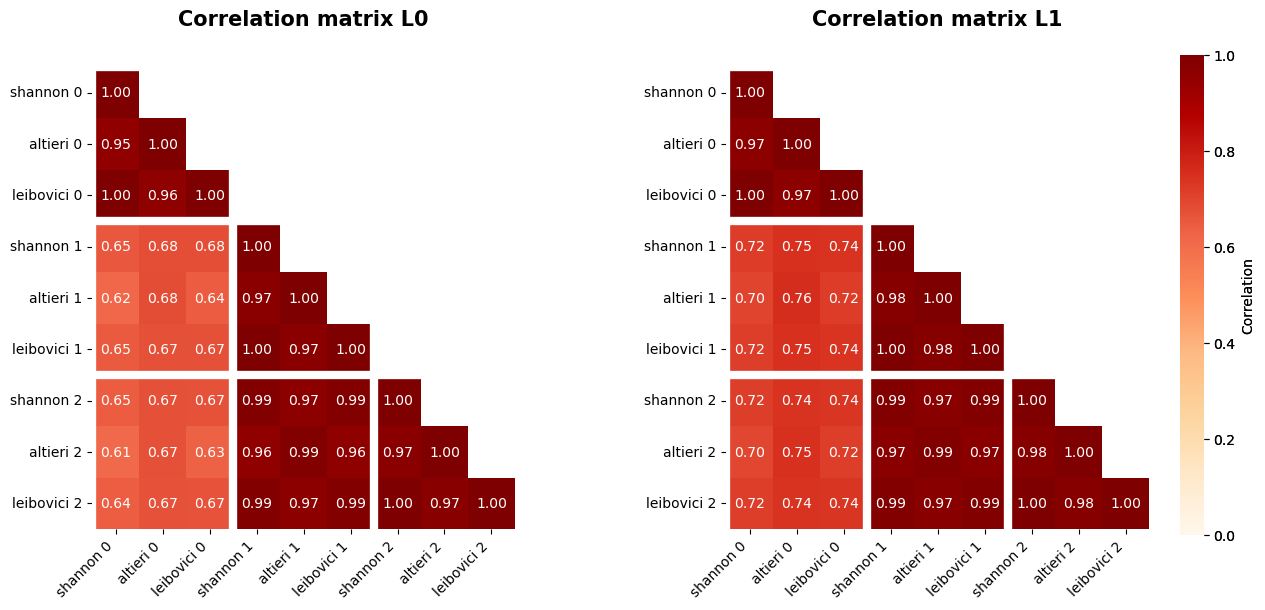

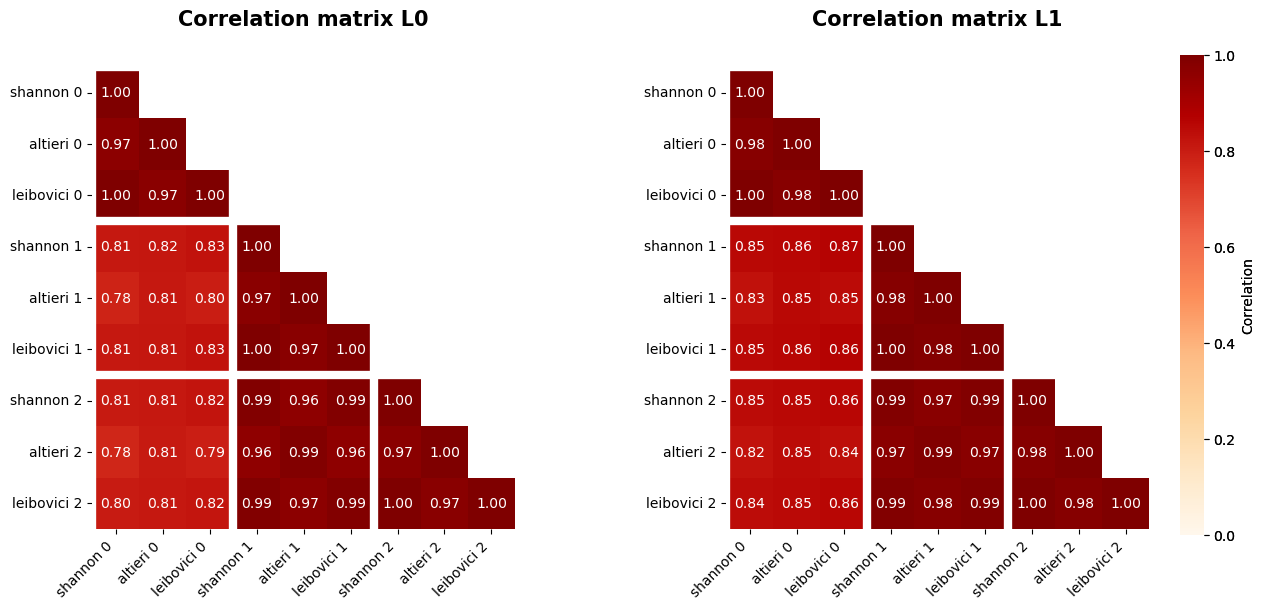

In [286]:
for gdf, scale in zip([gm, wk, bu], ['gm', 'wk', 'bu']):
    # regex all L0_x_x_norm columns
    regex = re.compile(r'L0_(shannon|altieri|leibovici)_\d{1}_norm')


    # make correlation matrix
    correlation = gdf.filter(regex='_norm$').corr()

    if 'L0_leibovici_0_norm' in correlation.columns:
        col_order_1 = [
                    'L0_shannon_0_norm',
                    'L0_altieri_0_norm', 
                    'L0_leibovici_0_norm',
                    'L0_shannon_1_norm',  
                    'L0_altieri_1_norm',
                    'L0_leibovici_1_norm',
                    'L0_shannon_2_norm', 
                    'L0_altieri_2_norm',
                    'L0_leibovici_2_norm',
                    ]
        col_order_2 = [
                    'L1_shannon_0_norm',
                    'L1_altieri_0_norm',
                    'L1_leibovici_0_norm',
                    'L1_shannon_1_norm',
                    'L1_altieri_1_norm',
                    'L1_leibovici_1_norm', 
                    'L1_shannon_2_norm',  
                    'L1_altieri_2_norm',  
                    'L1_leibovici_2_norm'
        ]
    else:
        col_order_1 = [
                    'L0_shannon_0_norm',
                    'L0_altieri_0_norm', 
                    'L0_shannon_1_norm',  
                    'L0_altieri_1_norm',
                    'L0_shannon_2_norm', 
                    'L0_altieri_2_norm',
                    ]
        col_order_2 = [
                    'L1_shannon_0_norm',
                    'L1_altieri_0_norm',
                    'L1_shannon_1_norm',
                    'L1_altieri_1_norm', 
                    'L1_shannon_2_norm',  
                    'L1_altieri_2_norm',  
        ]

    correlation_l0 = correlation.loc[col_order_1, col_order_1]
    correlation_l1 = correlation.loc[col_order_2, col_order_2]

    # rename columns to exclude L0, L1 and _norm
    correlation_l0.columns = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l0.columns]
    correlation_l0.index = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l0.index]
    correlation_l1.columns = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l1.columns]
    correlation_l1.index = [col.split('_')[1] + ' ' + col.split('_')[2] for col in correlation_l1.index]

    # plot correlation matrix with index and column names as labels, include legend
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    for i, correlation in enumerate([correlation_l0, correlation_l1]):
        
        mask = np.triu(np.ones_like(correlation.corr()), k=1)
        heatmap = sns.heatmap(correlation, annot=True, fmt=".2f", cmap='OrRd', cbar_kws={'label': 'Correlation'}, mask=mask, vmin=0, vmax=1, ax=ax[i])
        heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right')

        # move colorbar a bit to the right
        cbar = heatmap.collections[0].colorbar 
        # adjust cbar position
        cbar.ax.set_position([0.85, 0, 0.016, 1])

        # set title
        heatmap.set_title(f'Correlation matrix L{i}', fontsize=15, fontweight='bold', pad=30)

        # for i in range(3):
        #     heatmap.axvspan(i*3, i*3+3, color='white', alpha=0.1)
        #     heatmap.axhspan(i*3, i*3+3, color='white', alpha=0.1)

        # make group markings on the heatmap
        for i in range(3):
            heatmap.axvline(i*3, color='white', lw=6)
            heatmap.axhline(i*3, color='white', lw=6)
    
    plt.savefig(f'plots/correlation_{scale}_matrix.png', dpi=300)
